In [ ]:
# download the dataset 
# !gdown https://drive.google.com/uc?id=1Y4HWIEaZc8lQuf1SAYarGT2cBBrH7mnT
!gdown https://drive.google.com/uc?id=1jg6i8R1MSLMQtvHoU5EhUfzIiSEo2sEW
!unzip cats_final.zip

Downloading...
From: https://drive.google.com/uc?id=1jg6i8R1MSLMQtvHoU5EhUfzIiSEo2sEW
To: /content/cats_final.zip
249MB [00:01, 223MB/s]
Archive:  cats_final.zip
replace __MACOSX/._cats? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Mount drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# data loader
class StereoDataset(Dataset):
  def __init__(self, data_dir,
               device,
               dataset_name = 'CATS',
               mode = 'train',
               transform=None
               ):
    super(StereoDataset, self).__init__()
    self.data_dir     = data_dir
    self.dataset_name = dataset_name
    self.mode         = mode
    self.transform    = transform
    self.device       = device
    self.clahe        = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


    cats_data_dict = {
        'train': 'filenames/cats_train.txt',
        'val'  : 'filenames/cats_val.txt',
        'test' : 'filenames/cats_test.txt' 
    }

    cmu_data_dict = {
        'train': 'filenames/cmu_train.txt',
        'val'  : 'filenames/cmu_val.txt',
        'test' : 'filenames/cmu_test.txt' 
    }

    dataset_name_dict = {
        'CATS': cats_data_dict,
        'CMU': cmu_data_dict,
    }

    assert dataset_name in dataset_name_dict.keys()

    self.left_imgs, self.right_imgs, self.gt_imgs = self.get_file_names(dataset_name_dict[dataset_name][mode])

  def get_file_names(self, file_name_list):
    f = open(file_name_list, 'r')
    f = f.readlines()       
    left_arr, right_arr, gt_arr = [], [], []

    for line in f:
      line      = line.split('\n')[0]
      left_img  = self.data_dir + 'cats/left/'  + line
      right_img = self.data_dir + 'cats/right/' + line
      gt_img    = self.data_dir + 'cats/disp/'  + line.split('.')[0] + '.txt'

      gt_arr.append(gt_img)
      left_arr.append(left_img)
      right_arr.append(right_img)

    return left_arr, right_arr, gt_arr

  def __getitem__(self, index):
    left_img_path  = self.left_imgs[index]
    right_img_path = self.right_imgs[index]
    gt_img_path    = self.gt_imgs[index]

    # read the images
    left_img  = cv2.imread(left_img_path,  0)
    right_img = cv2.imread(right_img_path, 0)

    #left_img   = self.clahe.apply(left_img)
    #right_img  = self.clahe.apply(right_img)

    disp_img  = np.genfromtxt(gt_img_path, delimiter=',')
    disp_img  = (disp_img.astype(float))
    disp_img  += 70
    disp_img[disp_img < 0]   = 0.0
    disp_img[disp_img > 192] = 192.0
    
    left_img  = torch.unsqueeze(torch.from_numpy(left_img.astype(float)).float(),dim=0)   #permute(2, 0, 1)
    right_img = torch.unsqueeze(torch.from_numpy(right_img.astype(float)).float(),dim=0)  #permute(2, 0, 1)
    disp_img  = (torch.from_numpy(disp_img).float())

    if self.transform is not None:
      left_img, right_img, disp_img = self.transform(left_img), self.transform(right_img), self.transform(disp_img)
    
    return left_img, right_img, disp_img
  
  def __len__(self):
    return len(self.left_imgs)

In [ ]:
# Basic residual block from Kaimeng He's Resnet Paper:

class residual_block(nn.Module):
  def __init__(self,in_channel,out_channel,kernel,stride,padding,dilation):
    super(residual_block, self).__init__()

    self.in_channels = in_channel
    self.out_channels = out_channel
    self.stride = stride
    self.dilation = dilation

    layers = [nn.Conv2d(in_channel, out_channel, kernel, stride, padding, dilation = dilation, bias = False), nn.BatchNorm2d(out_channel),nn.ReLU(inplace=True), #nn.Dropout2d(p=0.3),
              nn.Conv2d(out_channel, out_channel, kernel, 1, padding,dilation=dilation, bias = False), nn.BatchNorm2d(out_channel)]

    self.layers = nn.Sequential(*layers)


  def forward(self,x):
    if self.in_channels == self.out_channels: # if-else block deals with the condition when number of channels change across residual/skip connection
      input = x
    else:
      diff = self.out_channels - self.in_channels
      x1 = torch.zeros(x.shape[0],diff,x.shape[2],x.shape[3]).to(device)
      input = torch.cat((x,x1),dim=1)


    if self.stride == 2: # Downsample input tensor when number of channels change across residual connections and stride is 2.
      input = F.max_pool2d(input,kernel_size = 2,stride = 2)

    output = self.layers(x)

    output += input
    
    output = F.relu(output)

    return output

In [ ]:
# CNN module of PSMNet:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    layers_1 = [
              nn.Conv2d(in_channels = 1,out_channels = 32, kernel_size = 3, stride = 2, padding = 1, bias = False), nn.BatchNorm2d(32),nn.ReLU(inplace=True), #nn.Dropout2d(p=0.3),   # H/2 x W/2 x 32 Conv0_1
              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(32),nn.ReLU(inplace=True), #nn.Dropout2d(p=0.3),# H/2 x W/2 x 32 Conv0_2
              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(32),nn.ReLU(inplace=True), #nn.Dropout2d(p=0.3),# H/2 x W/2 x 32 Conv0_3
              residual_block(32,32,3,1,1,1), residual_block(32,32,3,1,1,1), residual_block(32,32,3,1,1,1), # H/2 x W/2 x 32 Conv1_ 1-3
              residual_block(32,64,3,2,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), # Conv2_ 1-4
              residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), # Conv2_ 5-8
              residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), # Conv2_ 9-12
              residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1) # H/4 x W/4 x 64 Conv2_ 13-16
              ]
              
    layers_2 = [      
              residual_block(64,128,3,1,2,2), residual_block(128,128,3,1,2,2), residual_block(128,128,3,1,2,2), # H/4 x W/4 x 64 Conv3_ 1-3
              residual_block(128,128,3,1,4,4), residual_block(128,128,3,1,4,4), residual_block(128,128,3,1,4,4) # H/4 x W/4 x 64 Conv4_ 1-3 
              ]

    # Split sequential block into two lists to extract intermediate outputs for concatentaion in subsequent modules:

    self.layers_1 = nn.Sequential(*layers_1)
    self.layers_2 = nn.Sequential(*layers_2)

  def forward(self,x):
    cnn_concat1 = self.layers_1(x)
    cnn_concat2 = self.layers_2(cnn_concat1)
    return cnn_concat1,cnn_concat2 # Return two outputs(used further in concat operation)


In [ ]:
# SPP module of PSMNet:

class SPP(nn.Module):
  def __init__(self):
    super(SPP,self).__init__()

    self.cnn_module = CNN()

    self.branch1 = nn.Sequential(
                  nn.AvgPool2d(16,stride=16),
                  nn.Conv2d(in_channels = 128,out_channels = 32, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False), nn.BatchNorm2d(32), nn.ReLU(inplace=True)
                  ) # branch_1

    self.branch2 = nn.Sequential(
                  nn.AvgPool2d(8,stride=8),
                  nn.Conv2d(in_channels = 128,out_channels = 32, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False), nn.BatchNorm2d(32), nn.ReLU(inplace=True)
                  ) # branch_2

    self.branch3 = nn.Sequential(
                  nn.AvgPool2d(4,stride=4),
                  nn.Conv2d(in_channels = 128,out_channels = 32, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False), nn.BatchNorm2d(32), nn.ReLU(inplace=True)
                  ) # branch_3

    self.branch4 = nn.Sequential(
                  nn.AvgPool2d(2,stride=2),
                  nn.Conv2d(in_channels = 128,out_channels = 32, kernel_size = 1, stride = 1, padding = 0, bias = False), nn.BatchNorm2d(32), nn.ReLU(inplace=True)
                  ) # branch_4

    self.final_conv = nn.Sequential(
                    nn.Conv2d(in_channels = 320, out_channels =128, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 1, stride = 1, bias = False)
                    ) # fusion

  def forward(self,x):
    conv2_16,conv4_3 = self.cnn_module(x)
    branch1 = self.branch1(conv4_3)
    branch2 = self.branch2(conv4_3)
    branch3 = self.branch3(conv4_3)
    branch4 = self.branch4(conv4_3)
    branch1 = F.interpolate(branch1, (conv4_3.shape[2],conv4_3.shape[3]),mode='bilinear')
    branch2 = F.interpolate(branch2, (conv4_3.shape[2],conv4_3.shape[3]),mode='bilinear')
    branch3 = F.interpolate(branch3, (conv4_3.shape[2],conv4_3.shape[3]),mode='bilinear')
    branch4 = F.interpolate(branch4, (conv4_3.shape[2],conv4_3.shape[3]),mode='bilinear')
    concat_tensor = torch.cat((conv2_16,conv4_3,branch1,branch2,branch3,branch4), dim = 1) # Concat all pooled components (Concat block of SPP)
    spp_output = self.final_conv(concat_tensor)
    return spp_output


In [ ]:
# Custom class for disparity regression (Reference - https://github.com/JiaRenChang/PSMNet):

class disp_reg(nn.Module):
  def __init__(self, maxdisp):
    super(disp_reg, self).__init__()
    self.disp = Variable(torch.Tensor(np.reshape(np.array(range(maxdisp)),[1,maxdisp,1,1])).cuda(), requires_grad=False)

  def forward(self, x):
    disp = self.disp.repeat(x.size()[0],1,x.size()[2],x.size()[3])
    out  = torch.sum(x*disp,1)
    return out


In [ ]:
# PSM-Net model class definition (Trying with simple Basic 3D CNN architecture first!):
# Should take a stereo pair as input and do the rest. 

class PSMNET(nn.Module):
  def __init__(self,max_disp):
    super(PSMNET,self).__init__()

    self.max_disp = max_disp

    self.disp = self.max_disp // 4

    self.spp = SPP()

    self.cnn3d_1 = nn.Sequential(nn.Conv3d(in_channels = 64,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32), nn.ReLU(inplace=True),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32), nn.ReLU(inplace=True)) # 3DConv_1
    
    self.cnn3d_2 = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32), nn.ReLU(inplace=True),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32)) # 3DConv_2

    self.cnn3d_3 = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32), nn.ReLU(inplace=True),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32)) # 3DConv_3 

    self.cnn3d_4 = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32), nn.ReLU(inplace=True),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32)) # 3DConv_4

    self.cnn3d_5 = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32), nn.ReLU(inplace=True),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32)) # 3DConv_5
    
    self.cnn3d_last = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False), nn.BatchNorm3d(32), nn.ReLU(inplace=True),
                                    nn.Conv3d(in_channels = 32,out_channels = 1, kernel_size = 3, stride = 1, padding = 1, bias = False)) # 3DConv_final

    self.disp_reg = disp_reg(self.max_disp)


  def forward(self,left,right):
    left_feat  = self.spp(left) # Extract feature map from left image
    right_feat = self.spp(right) # Extract feature map from right image

    # Code for stacked cost volume (Reference - https://github.com/JiaRenChang/PSMNet):
    
    cost = torch.zeros(left_feat.shape[0], left_feat.shape[1] * 2, self.disp,  left_feat.shape[2], left_feat.shape[3]).float().cuda()

    for i in range(0, self.disp):
      if i > 0:
        cost[:, left_feat.shape[1]:, i, :, i:]   = left_feat[:,:,:,i:]
        cost[:, :left_feat.shape[1], i, :, i:]   = right_feat[:,:,:,:-i]
      else:
        cost[:, left_feat.shape[1]:, i, :, i:]   = left_feat
        cost[:, :left_feat.shape[1], i, :, i:]   = right_feat

    #

    cost = self.cnn3d_1(cost)
    cost = F.relu(self.cnn3d_2(cost) + cost) # Additions represent skip connections across 3D Conv layers
    cost = F.relu(self.cnn3d_3(cost) + cost)
    cost = F.relu(self.cnn3d_4(cost) + cost)
    cost = F.relu(self.cnn3d_5(cost) + cost)
    cost = self.cnn3d_last(cost)

    # Bilinear upsampling to restore image to original size:
    cost = F.interpolate(cost, (self.max_disp,left.shape[2],left.shape[3]), mode = 'trilinear') # GitHub repo uses trilinear for some reason. Trying bilinear for now!

    # Eliminate num_channels dimension(it's 1 anyway):
    cost = torch.squeeze(cost,1)
    
    # Compute softmax across all disparity values:
    cost = F.softmax(-cost,dim=1)

    #Perform disparity regression as defined in paper:
    pred = self.disp_reg(cost)

    return pred



In [ ]:
Batch_size = 2
train_set  = StereoDataset('/content/', device, dataset_name = 'CATS', mode = 'train',transform=None)
valid_set  = StereoDataset('/content/', device, dataset_name = 'CATS', mode = 'val',transform=None)

# Loader argument dictionary:
loader_args = dict(shuffle = True, batch_size = Batch_size, num_workers = 6, pin_memory = True) if torch.cuda.is_available()\
                   else dict(shuffle = True, batch_size = 2)

# Creating train and validation loaders:
train_loader = DataLoader(train_set,**loader_args)
valid_loader = DataLoader(valid_set,**loader_args)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def validate(val_dataloader, num_batch, model, loss_function):
  model.eval()
  running_loss, num_sequence = 0, 0

  with torch.no_grad():
    for i, (left_img, right_img, disp_img) in enumerate(val_dataloader):

      # the images go on the gpu
      left_img       = left_img.to(device)
      right_img      = right_img.to(device)
      disp_img_gt    = disp_img.to(device)

      disp_img_pred  = model.forward(left_img, right_img)
      loss           = loss_function(disp_img_pred, disp_img_gt)

      num_sequence, running_loss = num_sequence + 1, running_loss + loss.item()

      # Optimization snippet:
      del left_img,right_img

  print('Validation Loss = ' + str(running_loss/len(valid_set)))
  return (running_loss/len(valid_set))

def train(Batch_size, train_dataloader, val_dataloader):

  # Initialize PSMNET object and load it onto GPU:

  myModel = PSMNET(max_disp = 192)
  # model goes on the gpu
  myModel.to(device)
  # optimizer, params
  num_batch       = Batch_size
  num_epochs      = 500
  learning_rate   = 1e-3
  v_loss = 10000

  train_list = []
  valid_list = []
  epoch_list = []

  # initialize the optimizer
  optimizer     = torch.optim.AdamW(myModel.parameters(), lr=learning_rate, weight_decay = 1e-6)

  # initialize the lr scheduler
  scheduler     = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=250, verbose = True)

  # loss function, l1 loss with smoothness penalty
  loss_function = torch.nn.SmoothL1Loss(size_average=True)

  for epoch in range(num_epochs):

    running_loss, num_sequence = 0, 0
    train_loss = 0
    myModel.train(True)

    for i, (left_img, right_img, disp_img) in enumerate(train_dataloader):

      optimizer.zero_grad()

      # the images go on the gpu
      left_img       = left_img.to(device)
      right_img      = right_img.to(device)
      disp_img_gt    = disp_img.to(device)

      #print(disp_img_gt)

      disp_img_pred  = myModel.forward(left_img, right_img)
      loss = loss_function(disp_img_pred, disp_img_gt)
      loss.backward()
      optimizer.step()

      running_loss = running_loss + loss.item()

      del left_img
      del right_img

      torch.cuda.empty_cache()
      
    plt.imshow(disp_img_gt.cpu().numpy()[0, :, :])
    plt.show()
    plt.imshow(disp_img_pred.detach().cpu().numpy()[0, :, :])
    plt.show()

    print('EPOCH = ' + str(epoch))
    
    print('Training Loss = ' + str(running_loss/len(train_set)))
    train_loss = running_loss/len(train_set)

    with torch.no_grad():
      val_loss = validate(val_dataloader, num_batch, myModel, loss_function)

    # Plot training and validation loss:
    train_list.append(running_loss/len(train_set))
    valid_list.append(val_loss)
    epoch_list.append(epoch+1)

    plt.plot(epoch_list,train_list)
    plt.plot(epoch_list,valid_list)
    plt.show()

    scheduler.step()
    
    if val_loss < v_loss:
      v_loss = val_loss
      torch.save(myModel.state_dict(),'/content/gdrive/MyDrive/psmnet/model_no_equalize')

    torch.cuda.empty_cache()

Adjusting learning rate of group 0 to 1.0000e-03.


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


EPOCH = 0
Training Loss = 9.68164581934611
Validation Loss = 8.971321741739908


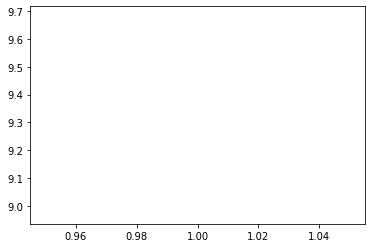

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 1
Training Loss = 8.760113595326741
Validation Loss = 8.543989870283339


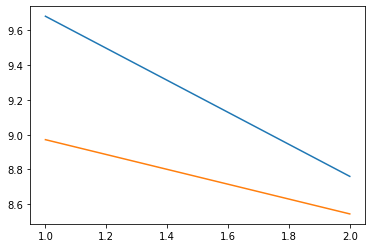

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 2
Training Loss = 8.336960074106852
Validation Loss = 7.118922233581543


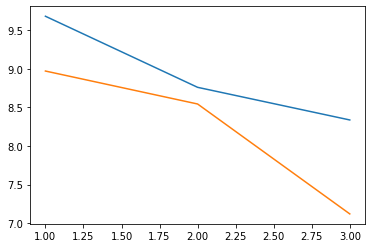

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 3
Training Loss = 7.785268681844076
Validation Loss = 7.350712935129802


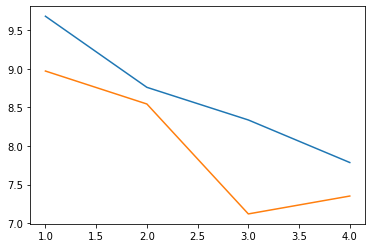

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 4
Training Loss = 7.468892523447672
Validation Loss = 5.987723721398248


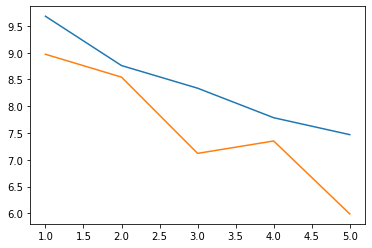

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 5
Training Loss = 7.653779303232829
Validation Loss = 7.069384309980604


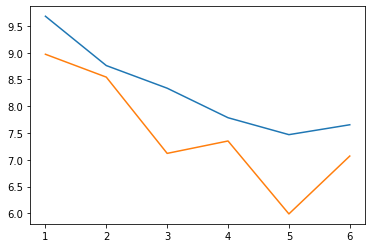

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 6
Training Loss = 7.081829102834066
Validation Loss = 5.902746942308214


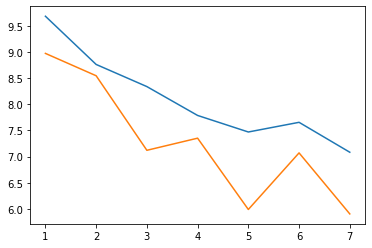

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 7
Training Loss = 6.546142168045044
Validation Loss = 6.03038051393297


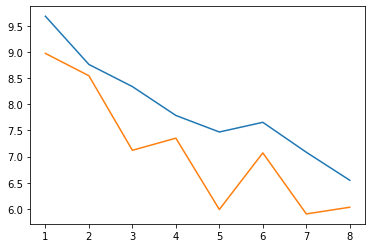

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 8
Training Loss = 6.212741854985555
Validation Loss = 5.79800197813246


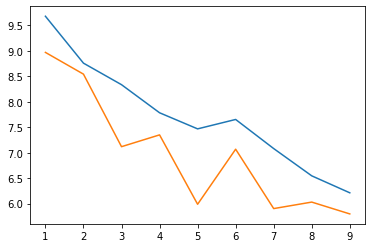

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 9
Training Loss = 5.920459499359131
Validation Loss = 5.142179436153835


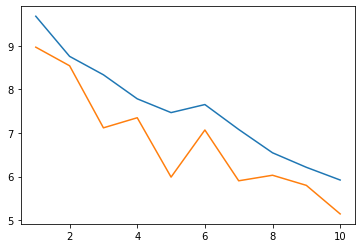

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 10
Training Loss = 5.600021518071492
Validation Loss = 5.175753222571479


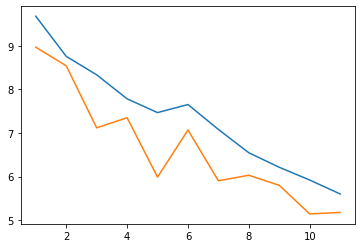

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 11
Training Loss = 5.475835466384888
Validation Loss = 4.885700517230564


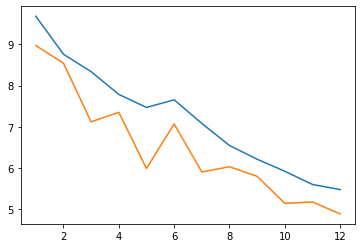

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 12
Training Loss = 5.396477053960164
Validation Loss = 5.031972832149929


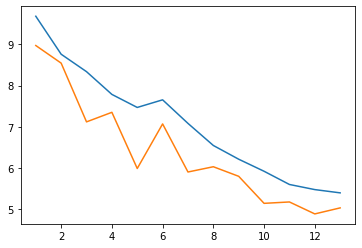

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 13
Training Loss = 5.352572580973307
Validation Loss = 4.714472426308526


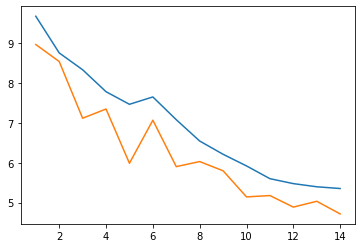

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 14
Training Loss = 5.304801403681437
Validation Loss = 5.291708045535618


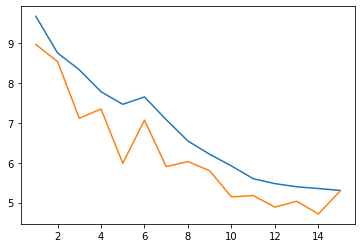

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 15
Training Loss = 5.039605644543966
Validation Loss = 5.066991355684069


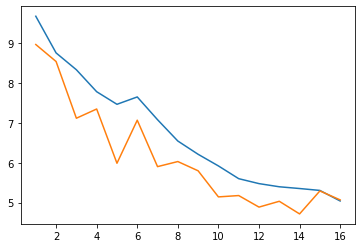

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 16
Training Loss = 5.222581154505412
Validation Loss = 4.925919797685411


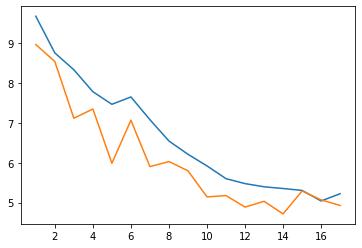

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 17
Training Loss = 5.029581319491069
Validation Loss = 4.708676868014866


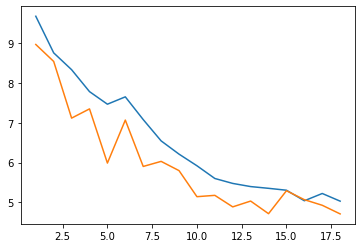

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 18
Training Loss = 4.94295024394989
Validation Loss = 4.621332433488634


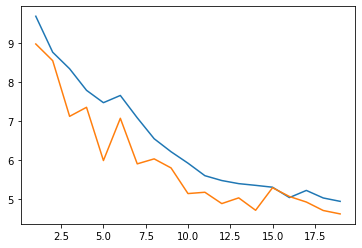

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 19
Training Loss = 5.087475721041361
Validation Loss = 4.9786209795210095


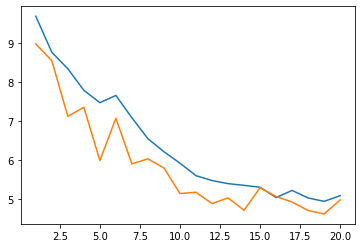

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 20
Training Loss = 5.010659246444702
Validation Loss = 5.258641242980957


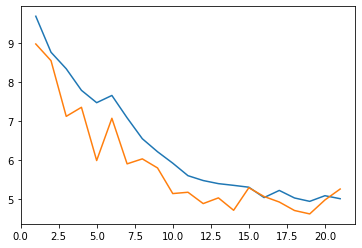

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 21
Training Loss = 4.791415816942851
Validation Loss = 4.728564818700154


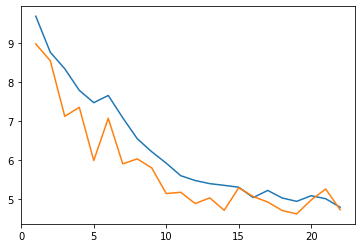

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 22
Training Loss = 4.735935430526734
Validation Loss = 5.517879486083984


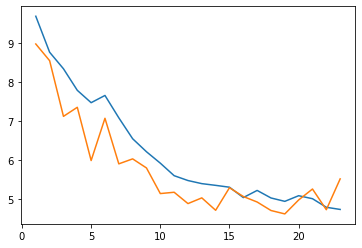

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 23
Training Loss = 4.803973228136698
Validation Loss = 4.458145644929674


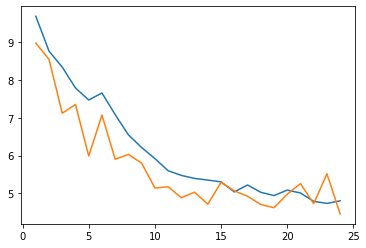

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 24
Training Loss = 4.8984491189320885
Validation Loss = 4.521401537789239


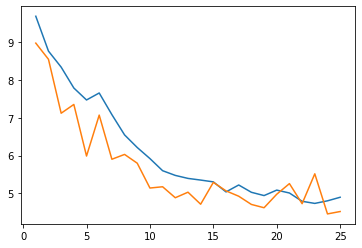

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 25
Training Loss = 4.661074862480164
Validation Loss = 4.3386365042792425


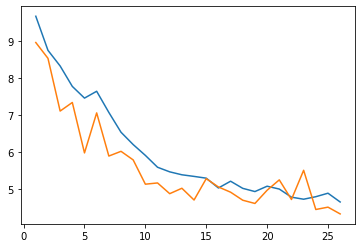

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 26
Training Loss = 4.619882237116496
Validation Loss = 4.380084938473171


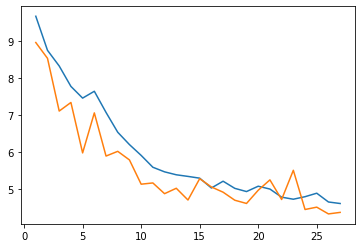

Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH = 27
Training Loss = 4.725443862279256
Validation Loss = 4.993129465315077


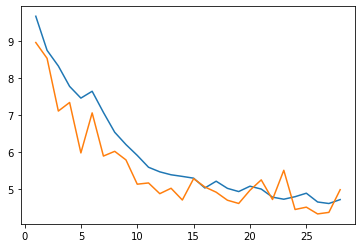

Adjusting learning rate of group 0 to 1.0000e-03.


KeyboardInterrupt: ignored

In [ ]:
train(Batch_size, train_loader, valid_loader)

In [ ]:
%mkdir /content/image_download
%mkdir /content/image_download/valid
%mkdir /content/image_download/valid_gt
%mkdir /content/image_download/train
%mkdir /content/image_download/train_gt

my_model = PSMNET(max_disp = 192)
my_model.to(device)
state_dict = (torch.load('/content/gdrive/MyDrive/psmnet/model_no_equalize'))
my_model.load_state_dict(state_dict)

my_model.eval()

k = 0
m = 0
f1 = open('filenames1/cats_val.txt', 'r')
f1 = f1.readlines()
f2 = open('filenames1/cats_train.txt', 'r')
f2 = f2.readlines()
with torch.no_grad():
  
  for i, (left_img, right_img, disp_img) in enumerate(valid_loader):
    # the images go on the gpu
    left_img       = left_img.to(device)
    right_img      = right_img.to(device)
    disp_img_gt    = disp_img.to(device)

    disp_img_pred  = my_model(left_img, right_img)

    # Save predictions in a folder
    for j in range(disp_img_pred.shape[0]):
      disp_pred = disp_img_pred[j,:,:].detach().cpu().numpy()
      disp_pred[disp_pred < 0] = 0
      disp_pred[disp_pred > 192.0] = 192.0
      plt.imsave('/content/image_download/valid/' + f1[m].split('\n')[0] ,disp_pred,cmap='gray')
      disp_gt = disp_img_gt[j,:,:].cpu().numpy()
      plt.imsave('/content/image_download/valid_gt/' + f1[m].split('\n')[0] ,disp_gt,cmap='gray')
      m += 1


  for i, (left_img, right_img, disp_img) in enumerate(train_loader):
    # the images go on the gpu
    left_img       = left_img.to(device)
    right_img      = right_img.to(device)
    disp_img_gt    = disp_img.to(device)

    disp_img_pred  = my_model(left_img, right_img)

    
    # Save predictions in a folder
    for j in range(disp_img_pred.shape[0]):
      disp_pred = disp_img_pred[j,:,:].detach().cpu().numpy()
      disp_pred[disp_pred < 0] = 0
      disp_pred[disp_pred > 192.0] = 192.0
      plt.imsave('/content/image_download/train/' + f2[k].split('\n')[0] ,disp_pred,cmap='gray')
      disp_gt = disp_img_gt[j,:,:].cpu().numpy()
      plt.imsave('/content/image_download/train_gt/' + f2[k].split('\n')[0] ,disp_gt,cmap='gray')
      # plt.imsave('/content/image_download/train/' + f2[k].split('\n')[0],disp_img_pred[j,:,:].detach().cpu().numpy(),cmap='gray')
      k += 1


In [ ]:
!zip -r thresh_low_avgPool.zip image_download/